### NPL Competition Studies Notebook (messy code)

- TODO:
    - add remove references function
    - do cluster scatter on SVD not pca
    - Dendrogram with heat map
    - tree of life
    - LDAvis
    

In [1]:
import pandas as pd
import sys
import os
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

if sys.platform == "linux":
    studies_path = "/home/wiktor/git/MasterThesis/Literature/Competition_Studies_Database/studies.json"
    authors_path = "/home/wiktor/git/MasterThesis/Literature/Competition_Studies_Database/authors.json"
    studies_location = "/home/wiktor/Dropbox/Git/MasterThesis/Literature/Competition_Studies_Database/"
else:    
    studies_path = "/Users/Wiktor/Dropbox/Git/MasterThesis/Literature/Competition_Studies_Database/studies.json"
    authors_path = "/Users/Wiktor/Dropbox/Git/MasterThesis/Literature/Competition_Studies_Database/authors.json"
    studies_location = "/Users/Wiktor/Dropbox/Git/MasterThesis/Literature/Competition_Studies_Database/"

def read_txt_studies(studies_location):
    """
    Reads all of the .txt files from given location
    
    Returns:
    - list of all texts
    """
    
    # Get .txt files from the directory
    study_files = [file for file in os.listdir(studies_location) if '.txt' in file]

    # Remove extensions
    study_labels = [x.split('.')[0] for x in study_files]

    # Create file paths from files and their location
    study_paths = [studies_location + x for x in study_files]


    studies = []
    for text in study_paths:

        with open(text, 'r') as file:
            studies.append(file.read().replace('\n', ' '))

    df_studies = pd.DataFrame()
    df_studies['document'] = studies
    df_studies['label'] = study_labels
    return df_studies

# Documents collection with labels
df_documents = read_txt_studies(studies_location)

# List of all documents
documents = df_documents['document'].tolist()

# List of labels
article_labels = df_documents['label'].tolist()


### Cleaning Corpa
Before continuing with analysis I have to clean the dataset. I achieve that in the following steps:
- tockenize each document, each word is seperate instance
- remove all non unicode characters, we are left with letters, numbers and _
- For now I exclude all nummeric characters
- Remove stop words from the data. Stop words are words that carry little information in written texts. Also depends on the `context`, e.g. hstatistic

In [2]:
# List of stopwords, can be extended see: Stone, Denis, Kwantes (2010)
STOPWORDS = ['for', 'a', 'of', 'the', 'and', 'to', 'in', 'at', 'is', 'by', 'are', 'has', 'as', 'ln', 'al', 'et',
            'countries', 'banking', 'financial', 'test', 'hstatistic', 'pr', 'cid', 'using', 'index','ﬁnancial',
            'efficiency', 'bikker', 'equation', 'loans','panzarrosse', 'shaffer', 'economics', 'income', 'eu', 'revenues', 'comercial',
            'avaliable', 'online', 'vol']

# Transform documents: tokenize and make lower case
texts = [[word for word in text.lower().split()] for text in documents]

# Exclude non unicode characters
texts = [[re.sub(r'\W+', '', word) for word in text] for text in texts]

# Exclude nummeric
texts = [[re.sub(r'[0-9]+', '', word) for word in text] for text in texts]

# Exclude stop words
texts = [[word for word in text if word not in STOPWORDS] for text in texts]

# Exclude empty
texts = [[word for word in text if word != ''] for text in texts]

### Author

In [3]:
from read_json import get_author_institution, get_study_author
import json


# Reading authors database
with open(os.path.join(authors_path)) as file:
    authors = json.load(file)

# Reading studies database
with open(os.path.join(studies_path)) as file:
    studies = json.load(file)
    
authors_institutions = get_author_institution(authors)
studies_authors = get_study_author(studies)
author = pd.merge(studies_authors, authors_institutions, right_on = 'author', left_on='author_index')
author.drop('author_index', inplace = True, axis = 1)
author = author.groupby(['author', 'study_index']).sum()
author = author.groupby(['study_index']).sum().reset_index()
# CB label
cb = author.loc[author['central bank'] > 0, :]['study_index'].tolist()


### TF-IDF and document similarity

One of the first steps in the analysis is to vectrorize the text using term frequency - inverse document frequency measure. This allows to standardize the term frequency used in the texts, however taking into consideration that terms that are frequent in all documents bring no new informaton. 
- First we use tfidf to get terms and their weights
    - `max_df`: maximum frequency within the documents a given feature can have to be used in the tfi-idf
    - `min_df`: % of documents term would have to be to be considered
    - `ngram_range`: this just means I'll look at unigrams, bigrams and trigrams

In [4]:
def get_similarity_matrix(text_as_string):
    """
    Function returns cosine similarity and tfidf_matrix using sklearn
    """
    tfidf_vectorizer = TfidfVectorizer(max_df = 0.9, min_df = 0.1, stop_words='english',
                                       use_idf=True, ngram_range=(1,2))
    
    # Calculate tfidf_matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(text_as_string)
    
    # Calculate cosine similarity, since it is based on tfidf it ranges [0,1], term frequencies cannot be negative
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    # List of the features used in the tf-idf matrix (vocabulary)
    tfidf_terms = tfidf_vectorizer.get_feature_names()
    
    return similarity_matrix, tfidf_matrix, tfidf_terms

def convert_list(content):
    """
    Function transforms list of vectorized documents into list of strings (one per document)
    
    Arguments:
    - list of vectorized texts (list of lists)
    """
    converted_content = []
    for index, str_list in enumerate(content):
        converted_content.append('')
        for item in str_list:
            converted_content[index] = converted_content[index] + ' ' + item
    return converted_content


converted_texts = convert_list(texts)

similarity_matrix, tfidf_matrix, tfidf_terms  = get_similarity_matrix(converted_texts)

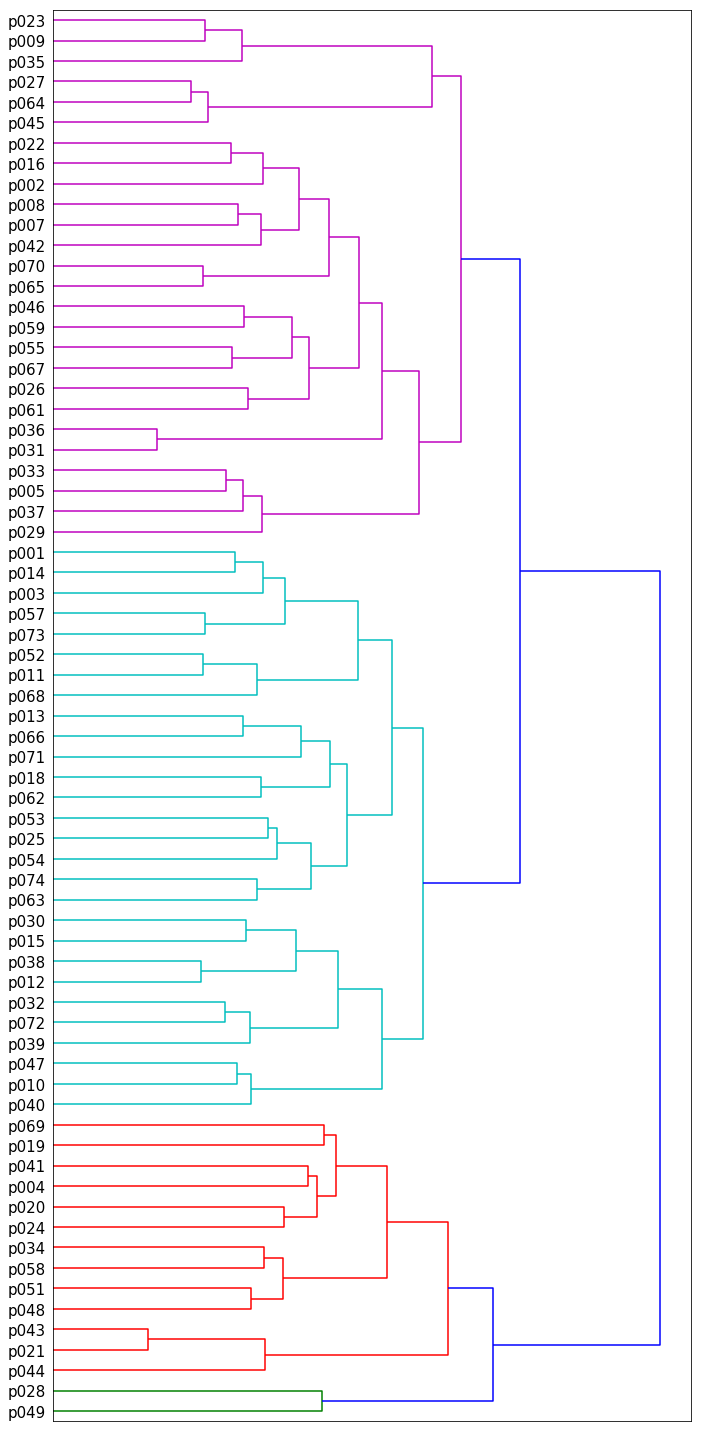

In [6]:
def dendogram(similarity_matrix, book_names):
    
    # Define the linkage_matrix using ward clustering pre-computed distances
    linkage_matrix = ward(similarity_matrix)

    # Set figure size
    fig, ax = plt.subplots(figsize=(10, 20)) 
    ax = dendrogram(linkage_matrix, orientation="right", labels=book_names);

    plt.tick_params(axis= 'x',
                    which='both',
                    bottom='off',
                    top='off',
                    labelbottom='off',
                    length = 15)
    plt.tick_params(axis= 'y',
                    which='both',
                    bottom='off',
                    top='off',
                    labelbottom='off',
                    labelsize = 15)
    
    plt.tight_layout()
    
dendogram(similarity_matrix, article_labels)

### LDA Topic modelling
- Since we are looking at papers with single topic the analysis confirms that some terms appear in most of the papers and creates
single big topic that covers 96.3% of the tokens

In [16]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import LatentDirichletAllocation

pyLDAvis.enable_notebook()

tfidf_vectorizer = TfidfVectorizer(max_df = 0.9, min_df = 0.1, stop_words='english',
                                   use_idf=True, ngram_range=(1,2))

tfidf_mat = tfidf_vectorizer.fit_transform(converted_texts)

lda_tfidf = LatentDirichletAllocation(n_components=5, random_state=1)

lda_tfidf.fit(tfidf_matrix)

pyLDAvis.sklearn.prepare(lda_tfidf, tfidf_mat, tfidf_vectorizer)

/Users/Wiktor/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:536: DeprecationWarning: The default value for 'learning_method' will be changed from 'online' to 'batch' in the release 0.20. This warning was introduced in 0.18.
  DeprecationWarning)


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      96.277746        1       1 -0.009004  0.000002
4       1.129175        1       2  0.002564  0.000597
3       0.865022        1       3  0.000893 -0.000080
0       0.864048        1       4  0.002742 -0.000257
1       0.864010        1       5  0.002805 -0.000262, topic_info=     Category      Freq                      Term     Total  loglift  logprob
term                                                                         
2181  Default  1.000000                   foreign  1.000000  30.0000  30.0000
4854  Default  1.000000                 statistic  1.000000  29.0000  29.0000
847   Default  1.000000                commercial  1.000000  28.0000  28.0000
3647  Default  0.000000                     panel  0.000000  27.0000  27.0000
1917  Default  1.000000                estimation  1.000000  26.0000  26.0000
1295  Default  0.000000                    crisis  0.000000  25.0000  25.0000
4445  Default  0.000000                      risk  0.000000  24.0000  24.0000
1524  Default  0.000000                 different  0.000000  23.0000  23.0000
4700  Default  0.000000               significant  0.000000  22.0000  22.0000
2910  Default  0.000000                    lerner  0.000000  21.0000  21.0000
989   Default  0.000000    competitive conditions  0.000000  20.0000  20.0000
3859  Default  0.000000                        pp  0.000000  19.0000  19.0000
4709  Default  0.000000                signiﬁcant  0.000000  18.0000  18.0000
3575  Default  0.000000                 operating  0.000000  17.0000  17.0000
1700  Default  0.000000                   effects  0.000000  16.0000  16.0000
1254  Default  0.000000                   country  0.000000  15.0000  15.0000
3192  Default  0.000000                   measure  0.000000  14.0000  14.0000
2385  Default  0.000000                       hhi  0.000000  13.0000  13.0000
2223  Default  0.000000                  function  0.000000  12.0000  12.0000
1436  Default  0.000000        dependent variable  0.000000  11.0000  11.0000
3138  Default  0.000000              market power  0.000000  10.0000  10.0000
849   Default  0.000000          commercial banks  0.000000   9.0000   9.0000
5543  Default  0.000000                      ﬁrms  0.000000   8.0000   8.0000
5237  Default  0.000000                   turkish  0.000000   7.0000   7.0000
5313  Default  0.000000                       use  0.000000   6.0000   6.0000
4781  Default  0.000000                     south  0.000000   5.0000   5.0000
3099  Default  0.000000                  marginal  0.000000   4.0000   4.0000
3313  Default  0.000000                    models  0.000000   3.0000   3.0000
4750  Default  0.000000                     small  0.000000   2.0000   2.0000
5049  Default  0.000000                   systems  0.000000   1.0000   1.0000
...       ...       ...                       ...       ...      ...      ...
5351   Topic5  0.002728             values market  0.212417   0.3962  -8.4885
1828   Topic5  0.002649                 equa tion  0.204882   0.4032  -8.5177
2933   Topic5  0.002682             levels market  0.208942   0.3957  -8.5055
3743   Topic5  0.002766          periods observed  0.219539   0.3774  -8.4744
3208   Topic5  0.002760   measurement conjectural  0.220183   0.3722  -8.4766
3121   Topic5  0.002721             market edward  0.215009   0.3817  -8.4909
240    Topic5  0.002668         asset composition  0.208322   0.3937  -8.5105
257    Topic5  0.002779                assets sum  0.225242   0.3564  -8.4697
3131   Topic5  0.002821            market longrun  0.235409   0.3273  -8.4547
687    Topic5  0.002754                case banks  0.225315   0.3467  -8.4790
1046   Topic5  0.002685    concentration measured  0.213119   0.3770  -8.5044
5109   Topic5  0.002740               terms total  0.224845   0.3440  -8.4838
3730   Topic5  0.002707               period data  0.218769   0.3592 

In [8]:
def get_cluster_kmeans(tfidf_matrix, num_clusters):
    """
    Cluster papers into groups using kmeans
    
    Return:
     - class labels
    """
    km = KMeans(n_clusters = num_clusters)
    km.fit(tfidf_matrix)
    cluster_list = km.labels_.tolist()
    
    return cluster_list

def pca_reduction(similarity_matrix, n_components):
    # If we substract 1 - similarity matrix we get proper distance measure
    one_min_sim = 1 - similarity_matrix
    
    pca = PCA(n_components=10)
    pos = pca.fit_transform(one_min_sim)
    x_pos, y_pos = pos[:, 0], pos[:, 1]
    
    return (x_pos, y_pos)

km_clusters = get_cluster_kmeans(tfidf_matrix, 2)
x_pca, y_pca = pca_reduction(similarity_matrix, 10)

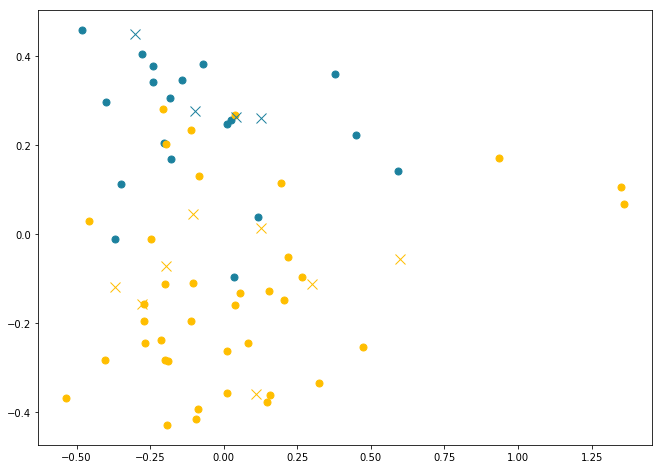

In [9]:
cb_mask = [ 1 if article in cb else 0 for article in article_labels]
fig, ax = plt.subplots(figsize=(11,8))
#plt.scatter(x_pca, y_pca, c= km_clusters)

for x, y, mask, cluster  in zip(x_pca, y_pca, cb_mask, km_clusters):
    if cluster == 1:
        color = '#ffbe00'
    if cluster == 0:
        color = '#1c819e'

    if mask == 1:
        ax.plot(x, y, marker='x', linestyle='', ms=10, c=color)
    else:
        ax.plot(x, y, marker='o', linestyle='', ms=7, c=color)

plt.show()


In [69]:
for compNum in range(0, 10):

    comp = pca.components_[compNum]
    
    # Sort the weights in the first component, and get the indeces
    indeces = np.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indeces.reverse()
    
    # Grab the top 10 terms which have the highest weight in this component.        
    terms = [tfidf_terms[weightIndex] for weightIndex in indeces[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indeces[0:10]]    

    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = np.arange(10) + .5    # the bar centers on the y axis
    
    plt.figure(compNum)
    plt.barh(positions, weights, align='center')
    plt.yticks(positions, terms)
    plt.xlabel('Weight')
    plt.title('Strongest terms for component %d' % (compNum))
    plt.grid(True)
    
plt.show()

NameError: name 'pca' is not defined

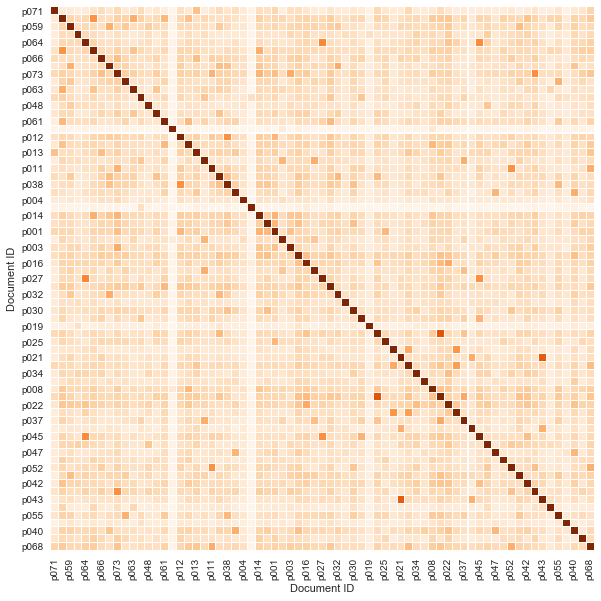

Text(0.5,0.98,'TF-IDF Document Similarity Matrix')

In [15]:
import seaborn as sns

sns.set(style="white")
sns.set(font_scale=1)
mask = np.zeros_like(similarity_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = False
heatmap_similarity = pd.DataFrame(similarity_matrix,
                                    columns = article_labels,
                                    index = article_labels)

f, ax = plt.subplots(figsize=(10,10))

c = sns.heatmap(heatmap_similarity,
                mask=mask,
                vmax=1,vmin =0,
                cmap="Oranges",
                cbar=False,
                square=True, linewidths=0.01,ax=ax)

c.set(xlabel='Document ID', ylabel='Document ID')
plt.show()
fig = c.get_figure()
fig.suptitle('TF-IDF Document Similarity Matrix')


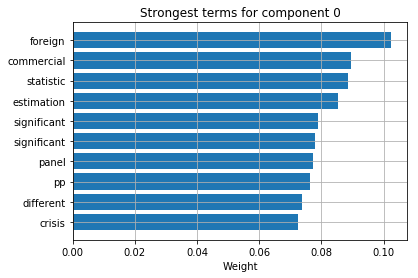

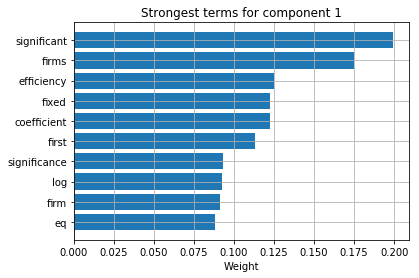

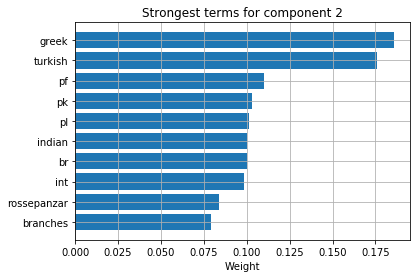

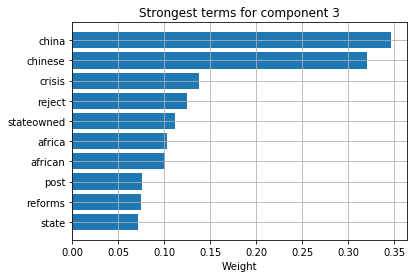

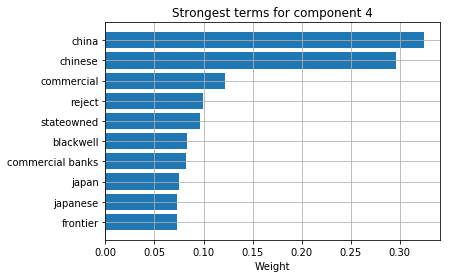

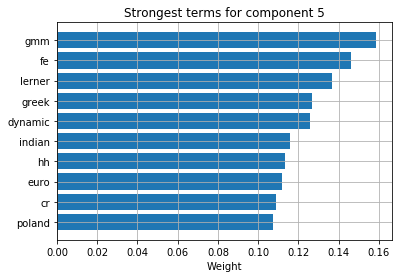

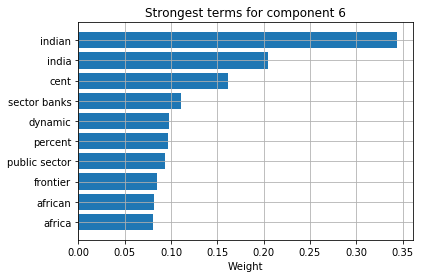

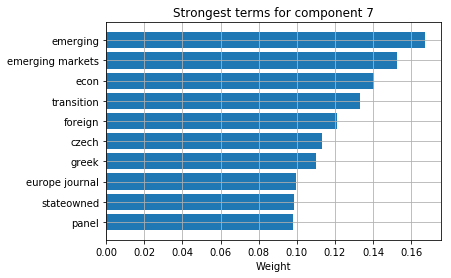

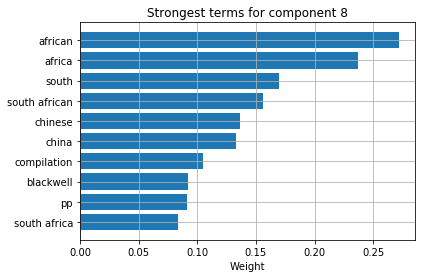

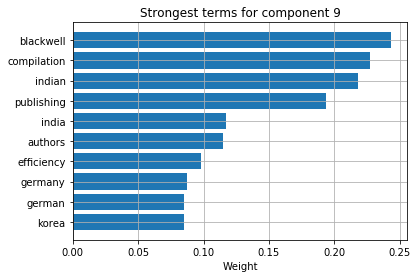

In [10]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt

svd = TruncatedSVD(100)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_tfidf = lsa.fit_transform(tfidf_matrix)

# The SVD matrix will have one row per component, and one column per feature
# of the original data.

for compNum in range(0, 10):

    comp = svd.components_[compNum]
    
    # Sort the weights in the first component, and get the indeces
    indeces = np.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indeces.reverse()
    
    # Grab the top 10 terms which have the highest weight in this component.        
    terms = [tfidf_terms[weightIndex] for weightIndex in indeces[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indeces[0:10]]    

    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = np.arange(10) + .5    # the bar centers on the y axis
    
    plt.figure(compNum)
    plt.barh(positions, weights, align='center')
    plt.yticks(positions, terms)
    plt.xlabel('Weight')
    plt.title('Strongest terms for component %d' % (compNum))
    plt.grid(True)
    
plt.show()

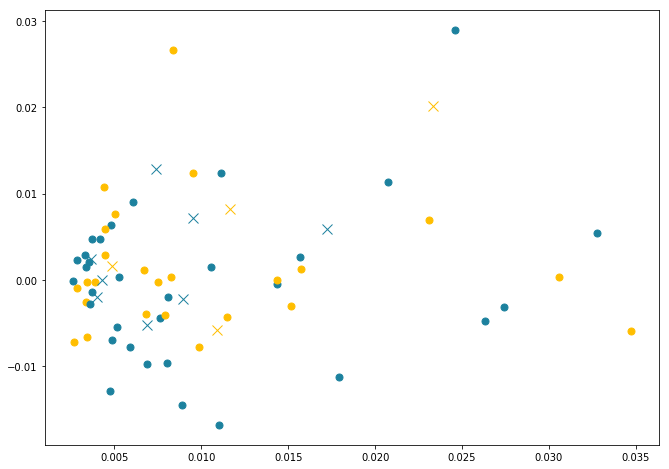

In [11]:
x_svd, y_svd = svd.components_[0], svd.components_[1]
km_clusters = get_cluster_kmeans(tfidf_matrix, 2)



cb_mask = [ 1 if article in cb else 0 for article in article_labels]
fig, ax = plt.subplots(figsize=(11,8))
#plt.scatter(x_pca, y_pca, c= km_clusters)

for x, y, mask, cluster  in zip(x_svd, y_svd, cb_mask, km_clusters):
    if cluster == 1:
        color = '#ffbe00'
    if cluster == 0:
        color = '#1c819e'
    if cluster == 2:
        color = '#dd0a35'
    if cluster == 3:
        color = '#2e5a1c'

    if mask == 1:
        ax.plot(x, y, marker='x', linestyle='', ms=10, c=color)
    else:
        ax.plot(x, y, marker='o', linestyle='', ms=7, c=color)

plt.show()